In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [3]:
df = pd.read_csv("Insurance Data/insurance - insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Q1. Do smokers have higher insurance charges than non-smokers?

### State Hypotheses:


***Null Hypothesis***: There is no difference in charges between smokers and non-smokers.

***Alternate Hypothesis***: Charges are higher for smokers than non-smokers.

### Select Test:

I will be using the 2-sample T-test since my comparison is between 2 samples/groups, "smokers and non-smokers" and also because it's a numerical data.

### Test Assumptions:

- No significant outliers
- Normality
- Equal Variance

In [4]:
# see how many smokers and non smokers we have
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [5]:
# Split the data into two groups
smoker_charges = df.loc[df['smoker'] == 'yes', "charges"]
non_smoker_charges = df.loc[df['smoker'] == 'no', "charges"]

### Checking Test Assumption

In [6]:
# Check for outliers in smokers
zscores_smoker = stats.zscore(smoker_charges)
outliers_smoker = abs(zscores_smoker)>3
np.sum(outliers_smoker)

0

In [7]:
# Check for outliers in non-smokers
zscores_non_smoker = stats.zscore(non_smoker_charges)
outliers_non_smoker = abs(zscores_non_smoker)>3
np.sum(outliers_non_smoker)

24

In [8]:
# Remove outliers
non_smoker_charges = non_smoker_charges[(np.abs(stats.zscore(non_smoker_charges)) < 3)]

In [9]:
# Normality test: smokers
result_smoker = stats.normaltest(smoker_charges)
result_smoker

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [10]:
# Normal test: non-smokers
result_non_smoker = stats.normaltest(non_smoker_charges)
result_non_smoker

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

- Both tests show that they're not normally distributed. However, we can proceed since our sample sizes are sufficient.

In [11]:
# Equal variance test
result = stats.levene(smoker_charges, non_smoker_charges)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

- Looks like we don't have equal variances, but that won't stop us! We just need to be sure to include "equal_var = False" when we perform our t-test.

### Executing Test

In [12]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(smoker_charges, non_smoker_charges, equal_var = False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.5753226625873578e-104)

### Interpretation

- Our p-value < alpha (0.05), so we reject the null hypothesis and accept that there is a significant difference between charges between smokers and non-smokers.

### Supporting Visualization

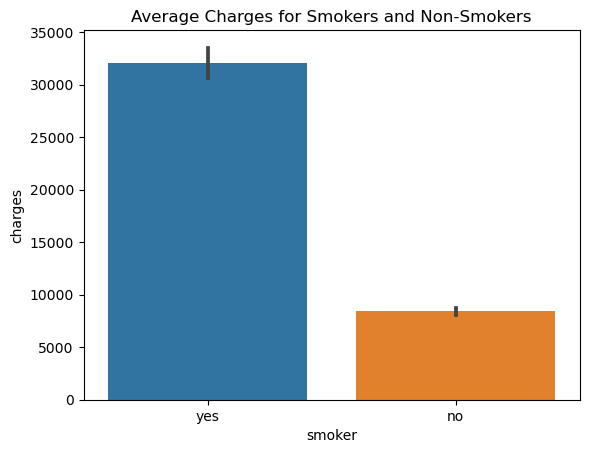

In [13]:
# Visual showing differences in average charges between both groups
ax = sns.barplot(data= df, x= 'smoker', y='charges')
ax.set_title('Average Charges for Smokers and Non-Smokers');

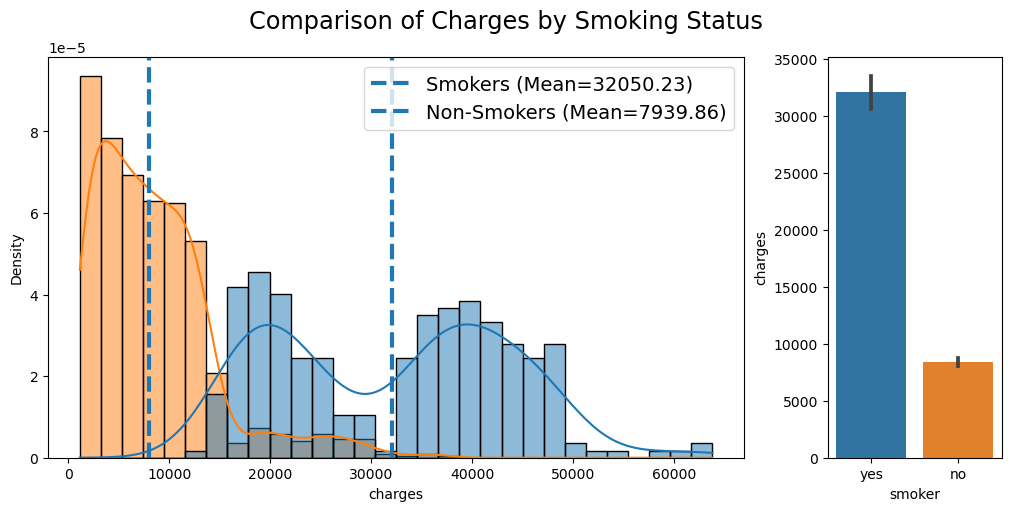

In [14]:
## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=df, x='charges',fill=True,hue='smoker',kde=True,
                  stat='density',common_norm=False,ax=ax)

ax.axvline(np.mean(smoker_charges), ls='--',lw=3, 
           label=f"Smokers (Mean={np.mean(smoker_charges):.2f})")

ax.axvline(np.mean(non_smoker_charges), ls='--', lw=3, 
           label=f"Non-Smokers (Mean={np.mean(non_smoker_charges):.2f})")

ax.legend(prop={"size":14}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
sns.barplot(data=df, x='smoker',y='charges',ax = ax_bar,)
fig.suptitle('Comparison of Charges by Smoking Status',fontsize='xx-large');

## Q2. Are men more likely to smoke than women?

### State Hypotheses:


***Null Hypothesis***: There is no difference between men and women's likelihood of smoking.

***Alternate Hypothesis***: Men are more likely to smoke than women.

### Select Test:

- I will be using the Chi-Squared test since my comparison is between 2 categorical samples/groups, "sex and smoker".

### Test Assumptions:

- There are two categorical variables (ordinal or nominal)
- The outcomes are independent.

In [15]:
# Create contingency table with pd.crosstab()
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [16]:
# Execute test
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result 

In [17]:
# Print p-value
print(p)
p<.05

0.006548143503580696


True

### Interpretation:

- P value is less then 0.05 so we will be rejecting the null hypothesis. There is a statistically significant difference between men and women smokers.


### Supporting Visual:

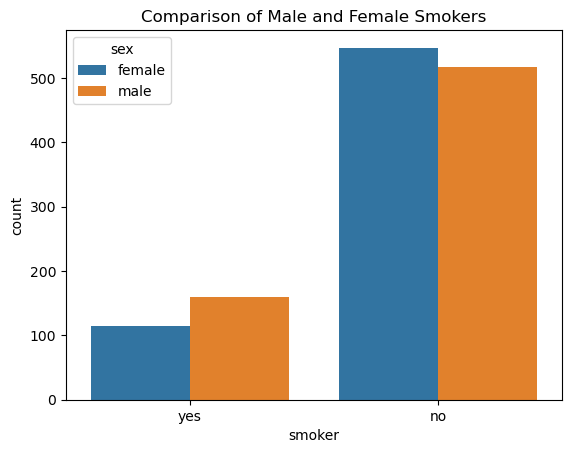

In [18]:
# Visualize counts of male and female smokers
ax = sns.countplot(data= df, x= 'smoker', hue= 'sex')
ax.set_title('Comparison of Male and Female Smokers');

- As the graph above shows: There are more males smokers than females and more female non-smokers than males

## Q3. Do different regions have different charges, on average?



### State Hypotheses:

- ***Null Hypothesis***: There are no differences in average charges by regions.

- ***Alternate Hypothesis***: There are differences in average charges by region.

### Select Test:

- I will be using the one-way ANOVA test since my comparison is between multiple samples/groups.

### Test Assumptions:

- No significant outliers
- Equal variance
- Normality

In [19]:
## Create groups dictionary.
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [20]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [21]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


- Our tests show that they're not normally distributed. However, we can proceed since our sample sizes are sufficient.

In [22]:
# Test for equal variance
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

- We didn't meet the assumption for this test, so I would run a Kruskal Wallis Test.

In [23]:
# ExecuteKruskal Wallis test
result = stats.kruskal(*groups)
result

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


KruskalResult(statistic=3.0, pvalue=0.3916251762710877)

- We do not have enough evidence to show that there are significant differences in charges in regions so this means we fail to reject the null hypothesis. This is because our p value was greater than our alpha 0.05.

### Supporting Visual:

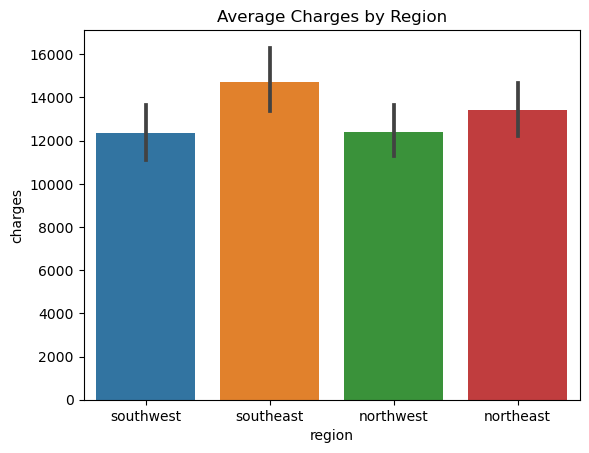

In [24]:
ax = sns.barplot(data=df, x='region',y='charges')
ax.set_title('Average Charges by Region');